In [6]:
!pip install finufft

In [1]:
!python3 -c "import pykeops; pykeops.clean_pykeops();"

[KeOps] /home/nizarben/.cache/keops2.2.3/Linux_ankhhaf_5.15.0-131-generic_p3.12.2 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


# NUFFT with KeOps and Applications


## 1. Recap of the Discrete Fourier Transform and FFT

### 1.1 Mathematical Background

Given a signal (or image) of length $N$, the Discrete Fourier Transform (DFT) is defined as:

$$
X_k = \sum_{n=0}^{N-1} x_n \, e^{-2 \pi i \frac{n k}{N}} \quad \text{for } k = 0, 1, \dots, N-1.
$$

- $x_n$: Samples in the time (or spatial) domain.
- $X_k$: DFT coefficients in the frequency domain.

The Fast Fourier Transform (FFT) computes the DFT in $O(N$log $N$$)$ time rather than $O(N^2)$.

### 1.2 Basic FFT Example in Python

Below is an example for a 1D signal:

We will be using `Numpy`'s `fft` class of methods


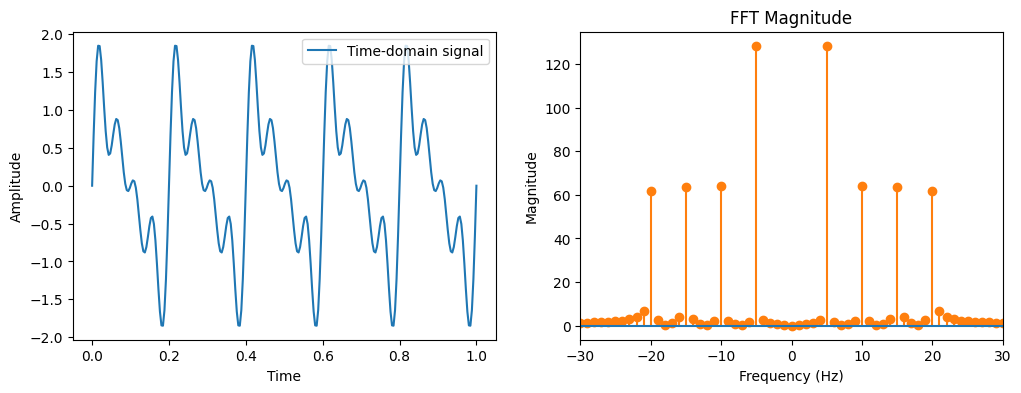

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create a time-domain signal
N = 256
t = np.linspace(0, 1, N)
freq1, freq2, freq3, freq4 = 5, 10, 15, 20  # 4 frequencies in Hz
signal = np.sin(2*np.pi*freq1*t) + 0.5*np.sin(2*np.pi*freq2*t) + 0.5*np.sin(2*np.pi*freq3*t) + 0.5*np.sin(2*np.pi*freq4*t)

# Compute FFT
fft_signal = np.fft.fft(signal)

# Frequency axis (for plotting)
freq_axis = np.fft.fftfreq(N, d=1/N)

# Plot time-domain and frequency-domain
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(t, signal, label="Time-domain signal")
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")
ax1.legend()

ax2.stem(freq_axis, np.abs(fft_signal), linefmt='C1-', markerfmt='C1o', basefmt='C0-')
ax2.set_xlim(-30, 30)  # zoom in on relevant freq range
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Magnitude")
ax2.set_title("FFT Magnitude")
plt.show()

## 2. From FFT to NUFFT

### 2.1 Why Non-Uniform FFT?

- The classic FFT requires uniform (equally spaced) samples.
- In many applications (e.g., MRI with radial or spiral trajectories, radio astronomy, radar), data are collected on non-uniform grids.
- The NUFFT computes the Fourier transform when either the input or output (or both) are non-uniformly sampled.

### 2.2 Mathematical Definition of NUFFT

Before starting, let's clarify the different NUFFT “types” and mathematical conventions:

- **Type-1 NUFFT (Nonuniform-to-Uniform):**

Given $M$ data points $x_j$ (in real domain) with values $c_j$, compute Fourier series coefficients on a *uniform frequency grid*. In 1D, this is
$$ F[k] = \sum_{j=0}^{M-1} c_j \; e^{\,i\, k\, x_j}, $$
for integer frequency index $k$ in a specified range (e.g. $-N/2 \le k < N/2$). This can be seen as computing a **DFT** of irregularly spaced samples $c_j = f(x_j)$. (The sign convention here uses $+i k x_j$, which corresponds to an inverse Fourier transform if $c_j$ were in time domain – we follow FINUFFT’s default convention for Type-1.)

- **Type-2 NUFFT (Uniform-to-Nonuniform):**

Given Fourier coefficients on a uniform grid, compute function values at $M$ arbitrary spatial points. In 1D:
$$ c_j = \sum_{k=-N/2}^{N/2-1} F[k] \; e^{\,i\, k\, x_j}, $$
producing values $c_j = f(x_j)$ at nonuniform locations $x_j$ from uniform frequency data $F[k]$. This is essentially an *inverse DFT* at arbitrary points.

- **Type-3 NUFFT (Nonuniform-to-Nonuniform):**

The most general case, mapping $M$ source points $\{x_j, c_j\}$ to $N$ target points $\{\omega_i\}$:
$$ \widehat{f}(\omega_i) = \sum_{j=0}^{M-1} c_j \; e^{\,i\, \omega_i\, x_j}, $$
for arbitrary real “frequency” points $\omega_i$ and source locations $x_j$. Type-3 covers both forward and inverse transforms depending on sign convention. (Often an $i$ or $-i$ is chosen based on forward/inverse; we will ensure consistency in code.)

### 2.3 Simple approximated NUFFT explanation

Conceptually, an approximated NUFFT implementation does:
1. **Spreading:** Map the non-uniform data onto a nearby uniform grid with a kernel.
2. **FFT:** Compute the FFT on the uniform grid.
3. **Deapodization / Correction:** Correct for the kernel interpolation.

## 3. Why KeOps for NUFFT?

KeOps is a library for large-scale kernel operations on GPUs. It offers:
- **Memory Efficiency:** It computes kernel sums on-the-fly without materializing huge matrices.
- **Speed:** JIT-compiles custom GPU kernels to perform the necessary summations quickly.
- **Flexibility:** It allows differentiable operations and custom kernel definitions.

For NUFFT, where you need to evaluate sums like

$$
X(\omega_k) = \sum_{n=0}^{N-1} x_n \, e^{-2 \pi i \, t_n \, \omega_k},
$$

KeOps lets you express the complex exponential kernel symbolically and reduces the sum efficiently on the GPU, which offers the possibility of implemented the real NUDFT that has an $O(N^2)$ complexity, in an efficient way.

## 4. Implementation and Comparisons

In the following sections, we implement NUFFT with KeOps and compare it against other libraries. We include:

- **Type‑1 NUFFT** 
- **Type‑3 NUFFT**
- **Numerical Comparisons** 

### 4.1 NUFFT with KeOps

Here we test that our **Type-1 NUFFT** computes the same result as a direct computation

In [3]:
import numpy as np
from pykeops.numpy import Genred

#Setup small test data  
M, N = 20, 16  
np.random.seed(42)
# M random points in [-pi, pi)
x = 2 * np.pi * np.random.rand(M) - np.pi  
# M random complex numbers, using complex128
c = np.random.randn(M) + 1j * np.random.randn(M)  

# Frequency indices: centered (for even N: [-N/2, ..., N/2-1])
if N % 2 == 0:
    k_indices = np.arange(-N//2, N//2, dtype=np.float64)
else:
    k_indices = np.arange(-N//2, N//2+1, dtype=np.float64)

# Direct computation for reference
F_direct = np.zeros(N, dtype=np.complex128)
for idx, k in enumerate(k_indices):
    F_direct[idx] = np.sum(c * np.exp(1j * k * x))

# Prepare inputs for KeOps with correct shapes
# Target frequencies: shape (N, 1)
k_vals = np.ascontiguousarray(k_indices.reshape(N, 1))
# Source positions: shape (M, 1) 
x_cont = np.ascontiguousarray(x.reshape(M, 1))
# Real and imaginary parts of c as (M, 1) arrays
c_real = np.ascontiguousarray(np.real(c).reshape(M, 1))
c_imag = np.ascontiguousarray(np.imag(c).reshape(M, 1))

# Define Keops formulas for real and imaginary parts
formula_real = Genred(
    "Sum(B0 * Cos(Xi * Yj) - B1 * Sin(Xi * Yj))",
    ["Xi=Vi(1)", "Yj=Vj(1)", "B0=Vj(1)", "B1=Vj(1)"],
    reduction_op="Sum",
    axis=1
)
formula_imag = Genred(
    "Sum(B0 * Sin(Xi * Yj) + B1 * Cos(Xi * Yj))",
    ["Xi=Vi(1)", "Yj=Vj(1)", "B0=Vj(1)", "B1=Vj(1)"],
    reduction_op="Sum",
    axis=1
)

F_real_keops = formula_real(k_vals, x_cont, c_real, c_imag)
F_imag_keops = formula_imag(k_vals, x_cont, c_real, c_imag)
F_keops = F_real_keops + 1j * F_imag_keops
F_keops = F_keops.flatten()  # convert to 1D array

print("Max absolute error (KeOps vs direct) =", np.max(np.abs(F_keops - F_direct)))
print("Are KeOps and direct results close? ", np.allclose(F_keops, F_direct, atol=1e-12))

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula c*Cos(a*b)-d*Sin(a*b) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula c*Sin(a*b)+d*Cos(a*b) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,1), d=Var(3,1,1) ... OK
Max absolute error (KeOps vs direct) = 2.094764613337708e-15
Are KeOps and direct results close?  True


Next, we test that our **Type-3 NUFFT** computes the same result as a direct computation

In [4]:
import numpy as np
from pykeops.numpy import Genred

#Small-scale type-3 NUFFT test
M, N = 15, 10 
np.random.seed(0)
# Generate M random source points in [-pi, pi)
x = 2 * np.pi * np.random.rand(M) - np.pi  
# Generate M random complex numbers
c = np.random.randn(M) + 1j * np.random.randn(M)
# Generate N random target frequencies in [-pi, pi)
omega = 2 * np.pi * np.random.rand(N) - np.pi  

# Direct computation for Type-3 NUFFT
f_direct = np.zeros(N, dtype=np.complex128)
for i in range(N):
    f_direct[i] = np.sum(c * np.exp(1j * omega[i] * x))

# Prepare inputs for KeOps with correct shapes
omega_vals = np.ascontiguousarray(omega.reshape(N, 1))
# Source positions: shape (M,1)
x_cont = np.ascontiguousarray(x.reshape(M, 1))
# Real and imaginary parts of c as (M,1) arrays
c_real = np.ascontiguousarray(np.real(c).reshape(M, 1))
c_imag = np.ascontiguousarray(np.imag(c).reshape(M, 1))

f_real_keops = formula_real(omega_vals, x_cont, c_real, c_imag)
f_imag_keops = formula_imag(omega_vals, x_cont, c_real, c_imag)
f_keops = f_real_keops + 1j * f_imag_keops
f_keops = f_keops.flatten()  # convert to a 1D array

print("Max |KeOps - direct| =", np.max(np.abs(f_keops - f_direct)))
print("Allclose (KeOps, direct)?", np.allclose(f_keops, f_direct, atol=1e-12))

Max |KeOps - direct| = 9.930136612989092e-16
Allclose (KeOps, direct)? True


In [12]:
import finufft
f_finufft = finufft.nufft1d3(x, c, omega, isign=1).flatten()
print("Max |FINUFFT - direct| =", np.max(np.abs(f_finufft - f_direct)))
print("Allclose (Finufft, direct)?", np.allclose(f_finufft, f_direct, atol=1e-4))

Max |FINUFFT - direct| = 6.659549517944105e-05
Allclose (Finufft, direct)? True


In [13]:
import time
import finufft
import pynvml

# Initialize NVML 
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # Change index if multiple GPUs exist

def get_gpu_memory():
    """Return the current GPU memory usage (in MB) on device 0."""
    meminfo = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return meminfo.used / (1024**2)

# Define KeOps formulas for the real and imaginary parts.
formula_real = Genred(
    "Sum(B0 * Cos(Xi * Yj) - B1 * Sin(Xi * Yj))",
    ["Xi=Vi(1)", "Yj=Vj(1)", "B0=Vj(1)", "B1=Vj(1)"],
    reduction_op="Sum",
    axis=1
)
formula_imag = Genred(
    "Sum(B0 * Sin(Xi * Yj) + B1 * Cos(Xi * Yj))",
    ["Xi=Vi(1)", "Yj=Vj(1)", "B0=Vj(1)", "B1=Vj(1)"],
    reduction_op="Sum",
    axis=1
)

def keops_type3(x, c, omega_vals):
    """
    Compute the Type-3 NUFFT using KeOps.
    x: (M,) array of source points (in [-pi,pi)).
    c: (M,) complex array of source coefficients.
    omega_vals: (N,1) array of target frequencies.
    """
    M = x.shape[0]
    # Ensure contiguous arrays and proper shapes.
    x_cont = np.ascontiguousarray(x.reshape(M, 1))
    c_real = np.ascontiguousarray(np.real(c).reshape(M, 1))
    c_imag = np.ascontiguousarray(np.imag(c).reshape(M, 1))
    # Compute KeOps-based NUFFT.
    f_r = formula_real(omega_vals, x_cont, c_real, c_imag)
    f_i = formula_imag(omega_vals, x_cont, c_real, c_imag)
    return (f_r + 1j * f_i).flatten()

def time_keops_type3(x, c, omega_vals, num_iter=10, warmup=True):
    """Time the KeOps Type-3 NUFFT over multiple iterations and measure GPU memory usage."""
    if warmup:
        _ = keops_type3(x, c, omega_vals)
    times = []
    mem_usages = []
    for _ in range(num_iter):
        start = time.time()
        _ = keops_type3(x, c, omega_vals)
        end = time.time()
        times.append(end - start)
        mem_usages.append(get_gpu_memory())
    avg_time = np.mean(times)
    avg_mem = np.mean(mem_usages)
    return avg_time, avg_mem

def time_finufft_type3(x, c, omega, num_iter=10, warmup=True):
    """Time the FINUFFT Type-3 NUFFT over multiple iterations (FINUFFT runs on CPU)."""
    if warmup:
        _ = finufft.nufft1d3(x, c, omega, isign=1)
    times = []
    for _ in range(num_iter):
        start = time.time()
        _ = finufft.nufft1d3(x, c, omega, isign=1)
        end = time.time()
        times.append(end - start)
    avg_time = np.mean(times)
    return avg_time

# Define larger problem sizes for benchmarking.
# Each tuple is (M, N): M = number of source points, N = number of target frequencies.
sizes = [
    (10000, 5000),
    (50000, 20000),
    # Uncomment depending on hardware capacity
    (100000, 50000)
]

print(f"{'M':>8} {'N':>8} {'KeOps Time (s)':>15} {'KeOps GPU Mem (MB)':>20} {'FINUFFT Time (s)':>15}")
for (M_val, N_val) in sizes:
    np.random.seed(42)  # For reproducibility.
    # Generate M random source points in [-pi, pi).
    x = 2 * np.pi * np.random.rand(M_val) - np.pi
    # Generate M random complex coefficients.
    c = np.random.randn(M_val) + 1j * np.random.randn(M_val)
    # Generate N random target frequencies in [-pi, pi).
    omega = 2 * np.pi * np.random.rand(N_val) - np.pi
    omega_vals = np.ascontiguousarray(omega.reshape(N_val, 1))
    
    keops_time, keops_mem = time_keops_type3(x, c, omega_vals, num_iter=10)
    finufft_time = time_finufft_type3(x, c, omega, num_iter=10)
    
    print(f"{M_val:8d} {N_val:8d} {keops_time:15.4f} {keops_mem:20.2f} {finufft_time:15.4f}")


       M        N  KeOps Time (s)   KeOps GPU Mem (MB) FINUFFT Time (s)
   10000     5000          0.0845             12480.50          0.0504
   50000    20000          0.8436             12480.50          0.0368
  100000    50000          3.6221             12480.50          0.0575


## 5. MRI Reconstruction Pipeline

MRI data are acquired in k-space. Here we simulate a full pipeline:

1. **Generate a Phantom:**  
   We use a Shepp–Logan phantom as a stand-in for an MRI image.

2. **Radial k-space Sampling:**  
   We define a radial trajectory and sample the phantom’s Fourier transform along these spokes.

3. **NUFFT-based Reconstruction:**  
   We compute a forward NUFFT to simulate acquisition and then apply the NUFFT adjoint to reconstruct the image.  
   (Note: In practice, one also applies density compensation; here a simple approach is shown.)

4. **Iterative Reconstruction (Compressed Sensing):**  
   We refine the reconstruction using an iterative method (e.g., conjugate gradient) to solve an inverse problem with a regularization term.

5. **Quality Metrics:**  
   We compute PSNR and SSIM to compare reconstruction quality.

### 5.1 Generate the Phantom

In [41]:
import time
import numpy as np
import matplotlib.pyplot as plt
import finufft
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pynvml
from pykeops.numpy import LazyTensor

def generate_shepp_logan(size=256):
    """Generate a Shepp-Logan phantom resized to (size x size)."""
    phantom = shepp_logan_phantom()
    phantom_resized = resize(phantom, (size, size), anti_aliasing=True)
    return phantom_resized.astype(np.float32)

def get_gpu_memory():
    """Return the current GPU memory usage (in MB) on device 0."""
    meminfo = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
    return meminfo.used / (1024**2)

def benchmark_function(func, args, num_iter=10, warmup=True):
    """Time a function over several iterations and return average time (s)."""
    if warmup:
        _ = func(*args)
    times = []
    for _ in range(num_iter):
        start = time.time()
        _ = func(*args)
        times.append(time.time() - start)
    return np.mean(times)

In [42]:
pynvml.nvmlInit()
gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)  # adjust index if needed

In [43]:
img_size = 256
phantom = generate_shepp_logan(img_size)

# Create coordinate grid for the image (spanning [-π, π) for consistency)
x_pts = np.linspace(-np.pi, np.pi, img_size, endpoint=False)
y_pts = np.linspace(-np.pi, np.pi, img_size, endpoint=False)
X_grid, Y_grid = np.meshgrid(x_pts, y_pts, indexing='xy')
image_coords_x = X_grid.ravel()  # shape (img_size^2,)
image_coords_y = Y_grid.ravel()

### 5.2 Radial k-space Sampling

In [44]:
n_radial = 36      # number of radial spokes
n_points = 200     # points per spoke (including center)
k_max = np.pi      # maximum k-space radius
angles = np.linspace(0, np.pi, n_radial, endpoint=False)
kx_list, ky_list = [], []
for theta in angles:
    kx_line = np.linspace(-k_max, k_max, n_points)
    # rotate line by theta: (kx, ky) = r * (cosθ, sinθ)
    kx_list.append(kx_line * np.cos(theta))
    ky_list.append(kx_line * np.sin(theta))
kx_samples = np.concatenate(kx_list)
ky_samples = np.concatenate(ky_list)
M_samples = len(kx_samples)
print(f"Total k-space samples: {M_samples}")

Total k-space samples: 7200


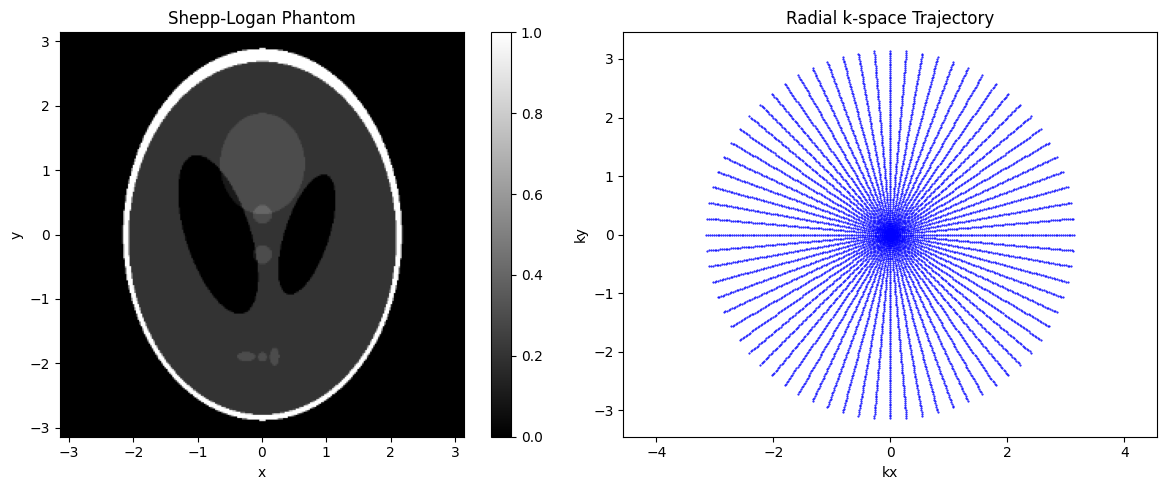

In [45]:
# Visualize the phantom and radial sampling trajectory
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(phantom, cmap='gray', extent=[-np.pi, np.pi, -np.pi, np.pi])
plt.title("Shepp-Logan Phantom")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

plt.subplot(1,2,2)
plt.plot(kx_samples, ky_samples, 'b.', markersize=1)
plt.title("Radial k-space Trajectory")
plt.xlabel("kx")
plt.ylabel("ky")
plt.axis('equal')
plt.tight_layout()
plt.show()

### 5.5 Iterative Reconstruction (Compressed Sensing)

A simple Conjugate Gradient (CG) method to refine the reconstruction:

Quality metrics (PSNR and SSIM) can be computed as follows: